# Sentiment analysis of movies reviews using machine learning <a class='tocSkip'></a>

## Project description <a class='tocSkip'></a>

Film Junky Union, a new cutting-edge community for classic movie fans, is developing a system for filtering and categorizing movie reviews. The goal of this project is to train a model to detect negative reviews automatically. To achieve this, I will use a dataset of IMDB movie reviews with polarity legends to build a model to classify positive and negative reviews. This should reach an F1 value of at least **0.85**.

# Initialization

In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
# Load libraries

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import re
import spacy
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from tqdm.auto import tqdm

nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

2023-04-04 12:44:40.596065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jesusrfl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# the following line provides better quality graphics on HiDPI displays
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [9]:
# this is for using progress_apply, you can read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Data Load

In [5]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
# df_reviews info
print(df_reviews.info())

# DataFrame head
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
# NaN values
print(df_reviews.isna().sum())

# Duplicated rows
print('Duplicated reviews:', df_reviews.duplicated('review').sum())

# Drop duplicated reviews
df_reviews = df_reviews.drop_duplicates(subset=['review'])

# Total number of reviews
print('Total number of reviews:', df_reviews.shape[0])

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64
Duplicated reviews: 91
Total number of reviews: 47240


There are two missing values in `average_rating` and `votes`. It is decided to keep these rows since the columns where the missing values appear will not be used to build the model.

There are 91 duplicated reviews, these were dropped from the DataFrame. The final DataFrame has 47,240 revies.

## Exploratory Data Analysis

Let's look at the number of movies and reviews over the years.

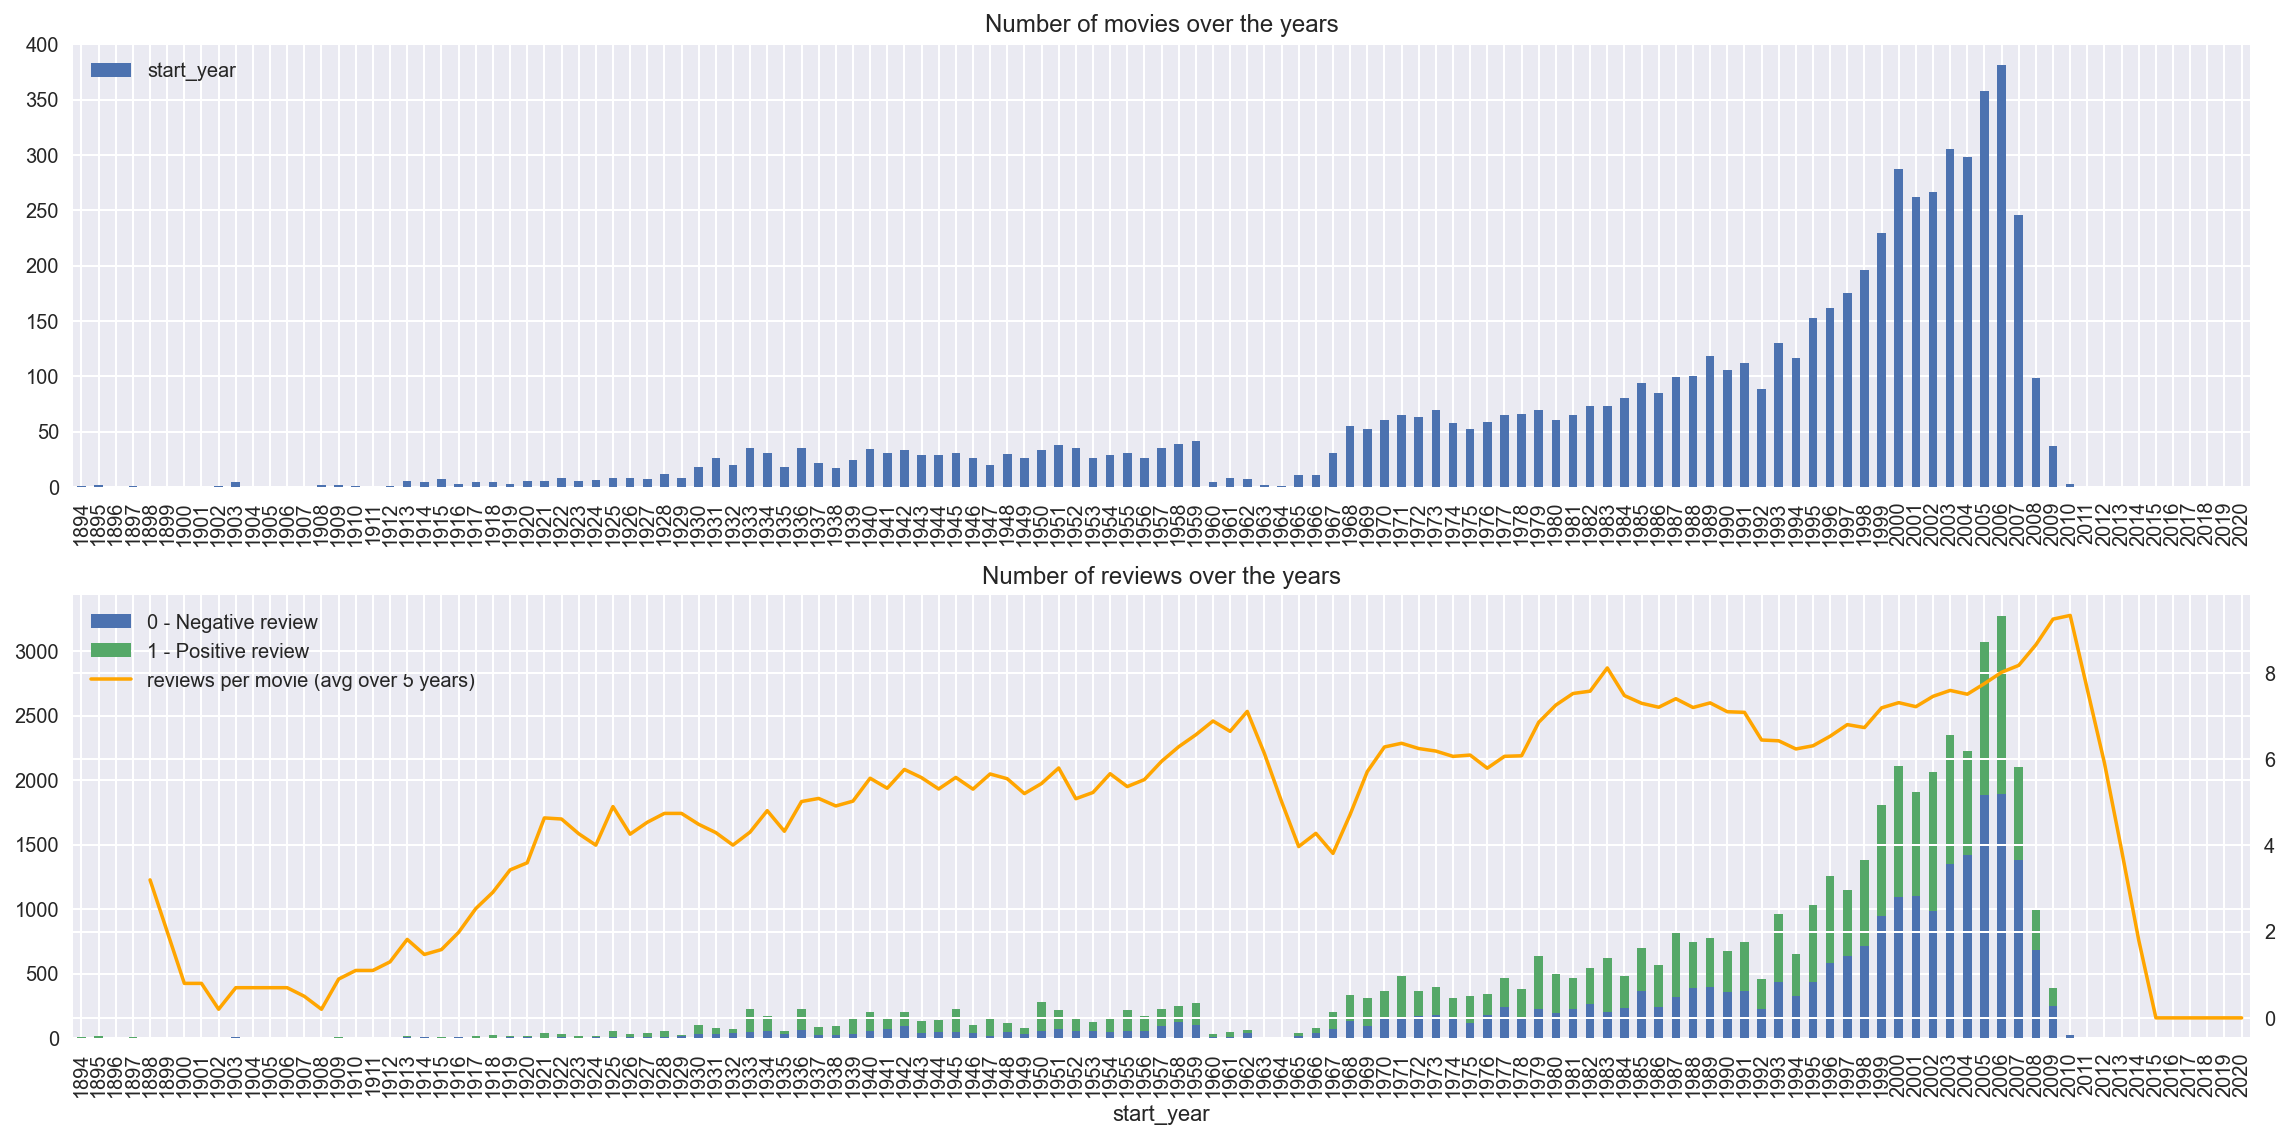

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies over the years')
ax.legend(loc='upper left')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)
ax.legend()

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()

dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)
lines, labels = ax.get_legend_handles_labels()
labels = ['0 - Negative review', '1 - Positive review']
lines_2, labels_2 = axt.get_legend_handles_labels()
ax.legend(lines + lines_2, labels + labels_2, loc='upper left')
ax.set_title('Number of reviews over the years')
fig.tight_layout()

Our dataset comprises films released between 1984 and 2010. The highest number of films released was recorded in 2006.

The average number of reviews per film accumulated every 5 years shows a tendency to increase over time.

Let's look at the distribution of the number of reviews per movie with the exact count and KDE (just to see how it can differ from the exact count).

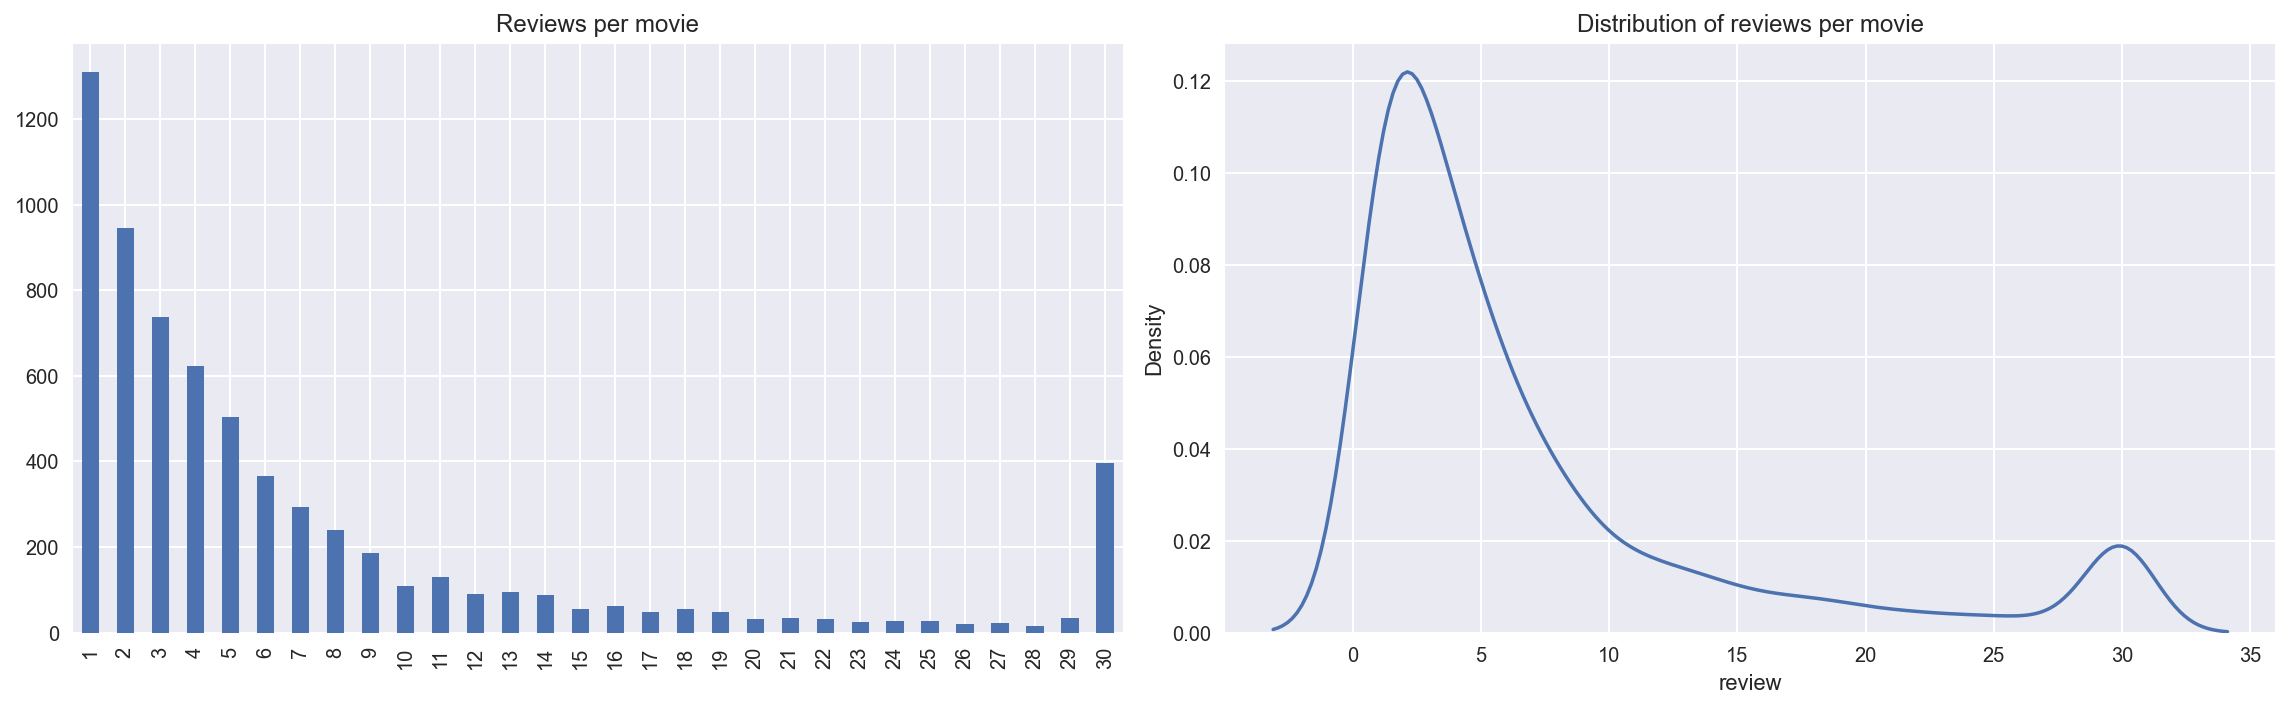

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Reviews per movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Distribution of reviews per movie')

fig.tight_layout()

The number of reviews per movie shows a distribution skewed to the left, that is, most of the movies have few reviews. However, there are at least 400 movies that have 30 reviews. Maybe these movies are blockbusters.

Now we are going to count the number of positive and negative reviews and explore whether there is a imbalance of classes.

In [16]:
# Total, number of positive and negative reviews
print(df_reviews.value_counts('pos', normalize=True),'\n')

# Train, number of positive and negative reviews
print(df_reviews.loc[df_reviews['ds_part']=='train'].value_counts('pos', normalize=True),'\n')

# Test, number of positive and negative reviews
print(df_reviews.loc[df_reviews['ds_part']=='test'].value_counts('pos', normalize=True),'\n')

pos
0    0.50127
1    0.49873
dtype: float64 

pos
0    0.500695
1    0.499305
dtype: float64 

pos
0    0.501852
1    0.498148
dtype: float64 



The proportion of classes is balanced for the total data and for each set (training and testing).

Now let's see if the `rating` of the movies, which goes from 1 to 10, is also balanced between the training and test sets.

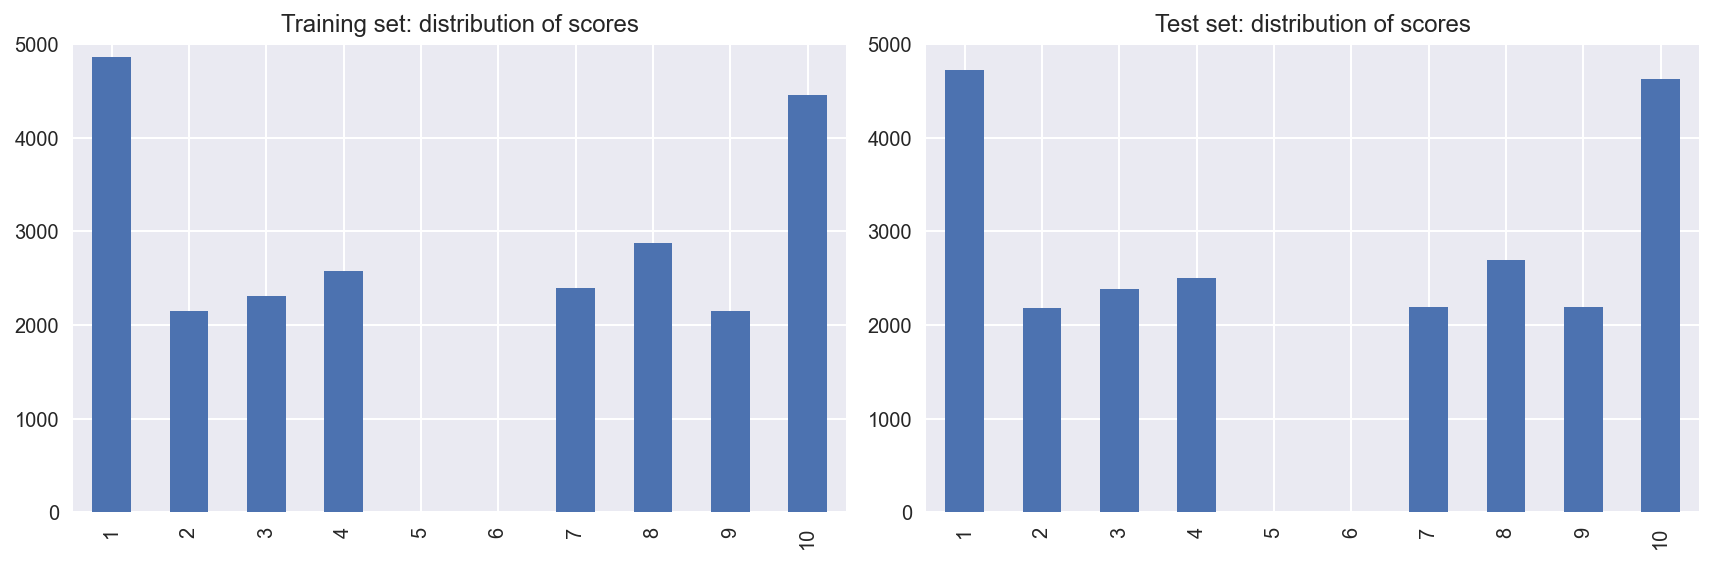

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training set: distribution of scores')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribution of scores')

fig.tight_layout()

It seems that the sets show the same pattern of distribution in terms of the number of films in each level of `rating`.

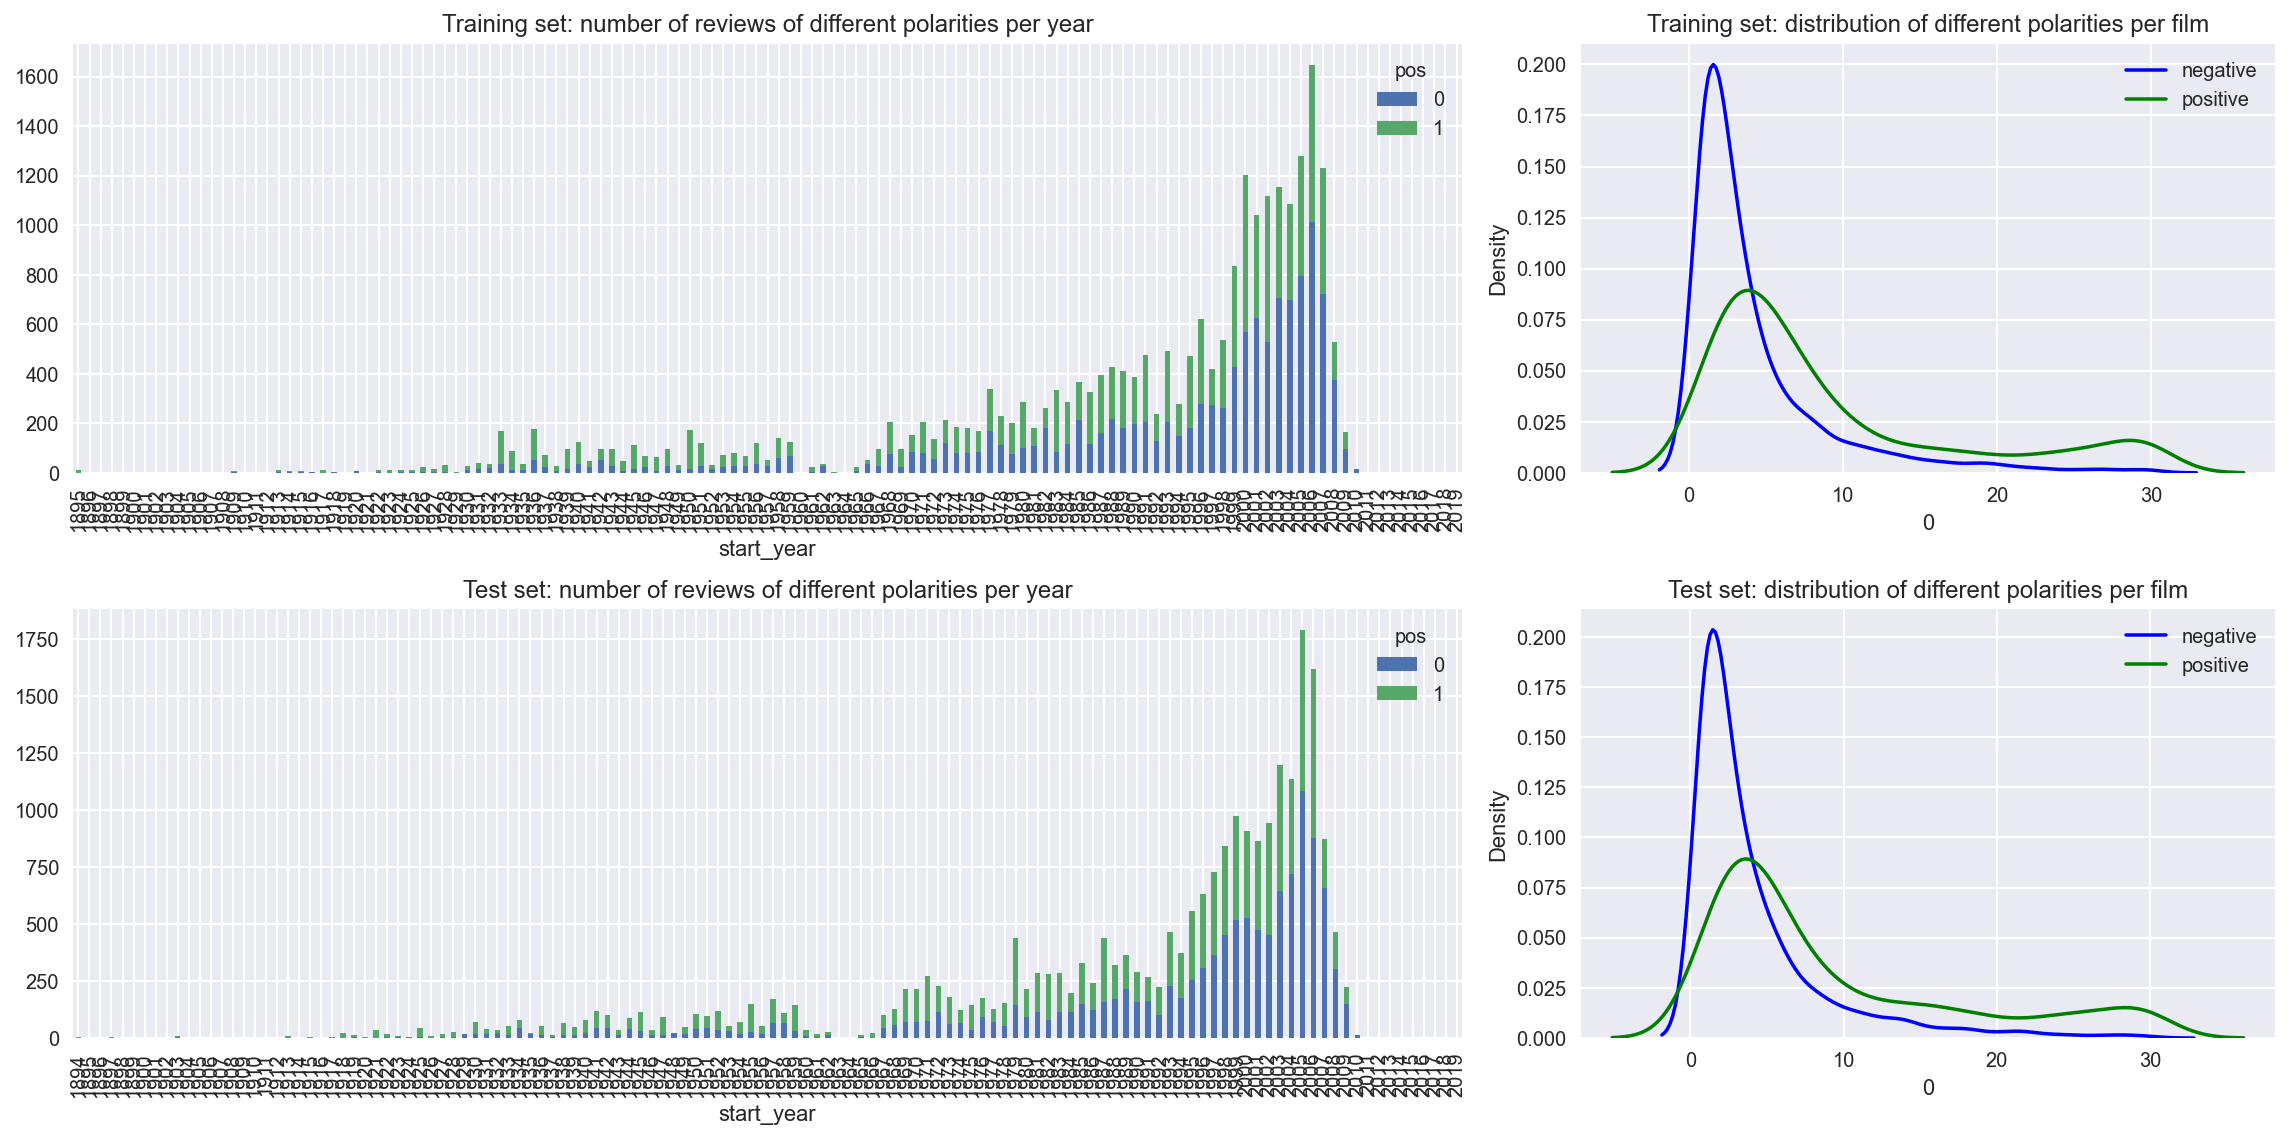

In [19]:
# Distribution of negative and positive reviews over the years for two parts of the data set
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Training set: distribution of different polarities per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribution of different polarities per film')

fig.tight_layout()

The distribution of positive and negative reviews is similar between the training and test sets.

We are going to review how extensive a review is in terms of characters.

In [20]:
# Number of characters per review type (1, 0)
df_reviews['length'] = df_reviews['review'].str.len()

df_reviews.groupby('pos')['length'].mean()

pos
0    1273.349747
1    1308.163964
Name: length, dtype: float64

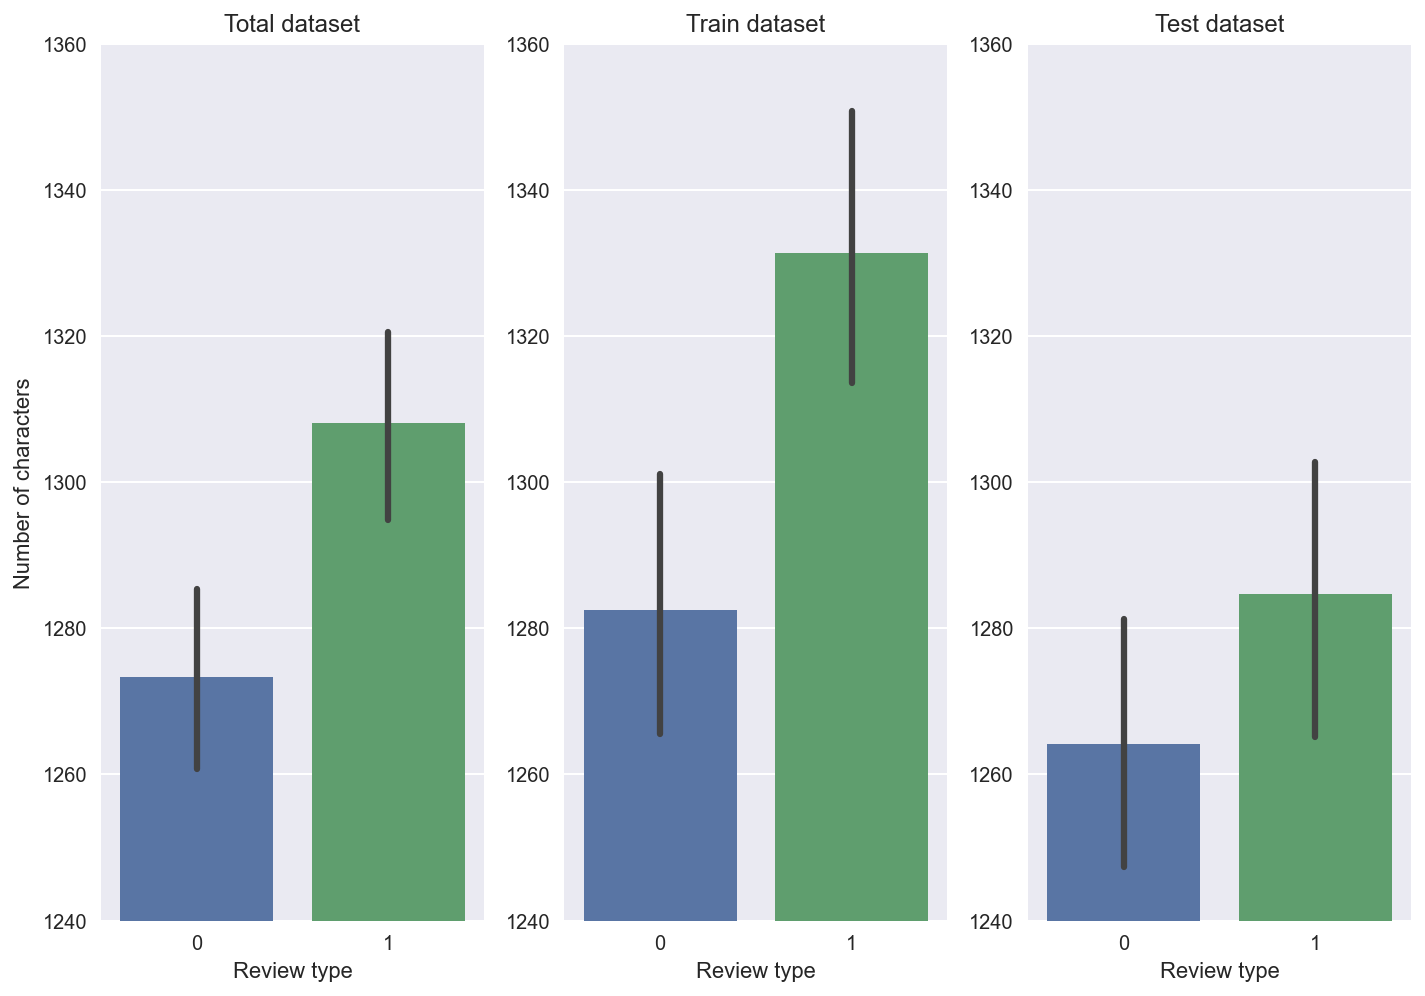

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7))

ax0 = axs[0]
sns.barplot(data=df_reviews, x='pos', y='length', ax=ax0)
ax0.set_ylim(1240, 1360)
ax0.set_title('Total dataset')
ax0.set_ylabel('Number of characters')
ax0.set_xlabel('Review type')

ax1 = axs[1]
sns.barplot(data=df_reviews.loc[df_reviews['ds_part']=='train'], x='pos', y='length', ax=ax1)
ax1.set_ylim(1240, 1360)
ax1.set_title('Train dataset')
ax1.set_ylabel('')
ax1.set_xlabel('Review type')

ax2 = axs[2]
sns.barplot(data=df_reviews.loc[df_reviews['ds_part']=='test'], x='pos', y='length', ax=ax2)
ax2.set_ylim(1240, 1360)
ax2.set_title('Test dataset')
ax2.set_ylabel('')
ax2.set_xlabel('Review type')

fig.tight_layout()

Positive reviews (`1`) tend to be on average longer than negative reviews (`0`) in both the training and test sets.

## Evaluation process

In this section it is define the fucntion **`evaluate_model`** which performs an evaluation rutine. This function returns:

* Accuracy score
* F1 score
* Average Precision Score (APS)
* AUC score

In [25]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Standardization

Here I standarize the reviews by transforming all the text into lower case, remove digits and punctiation symbols. The transformed reviews will be saved in the column `review_norm`

In [26]:
# Change reviews to lower case, remove digits and punctuation marks

def clear_text(text):
    clean_text = re.sub(r"[^a-zA-Z]", ' ', text)
    clean_text = " ".join(word_tokenize(clean_text))
    return clean_text.lower()

In [28]:
pd.set_option('display.max_colwidth', 100)


df_reviews['review_norm']= df_reviews['review'].apply(clear_text)

df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but th...
1    how the hell did they get this made presenting itself as a caper comedy the misbegotten is essen...
2    there is no real story the film seems more like a fly on the wall drama documentary than a prope...
3    um a serious film about troubled teens in singapore a country i have not much knowledge on but h...
4    i m totally agree with garryjohal from singapore s comments about this film quotation yes non si...
Name: review_norm, dtype: object

## Data subsetting (train / test)

The dataset is already divided into training/test parts; 'ds_part' is the corresponding flag.

In [29]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23757, 19)
(23483, 19)


## Machine learning models for texts

### Model 0 - Constant model

A dummy model will be trained with the lemmatized revisions, that is, each word will be reduced to its root. The normalized training and test features will be stored in the `f_train_rev` and `f_test_rev` lists respectively.

In [30]:
# Get features using lemmatized revisions
f_train_rev = df_reviews_train['review_norm']
f_test_rev  = df_reviews_test['review_norm']

In [31]:
model_0 = DummyClassifier()
model_0.fit(f_train_rev, train_target)

DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


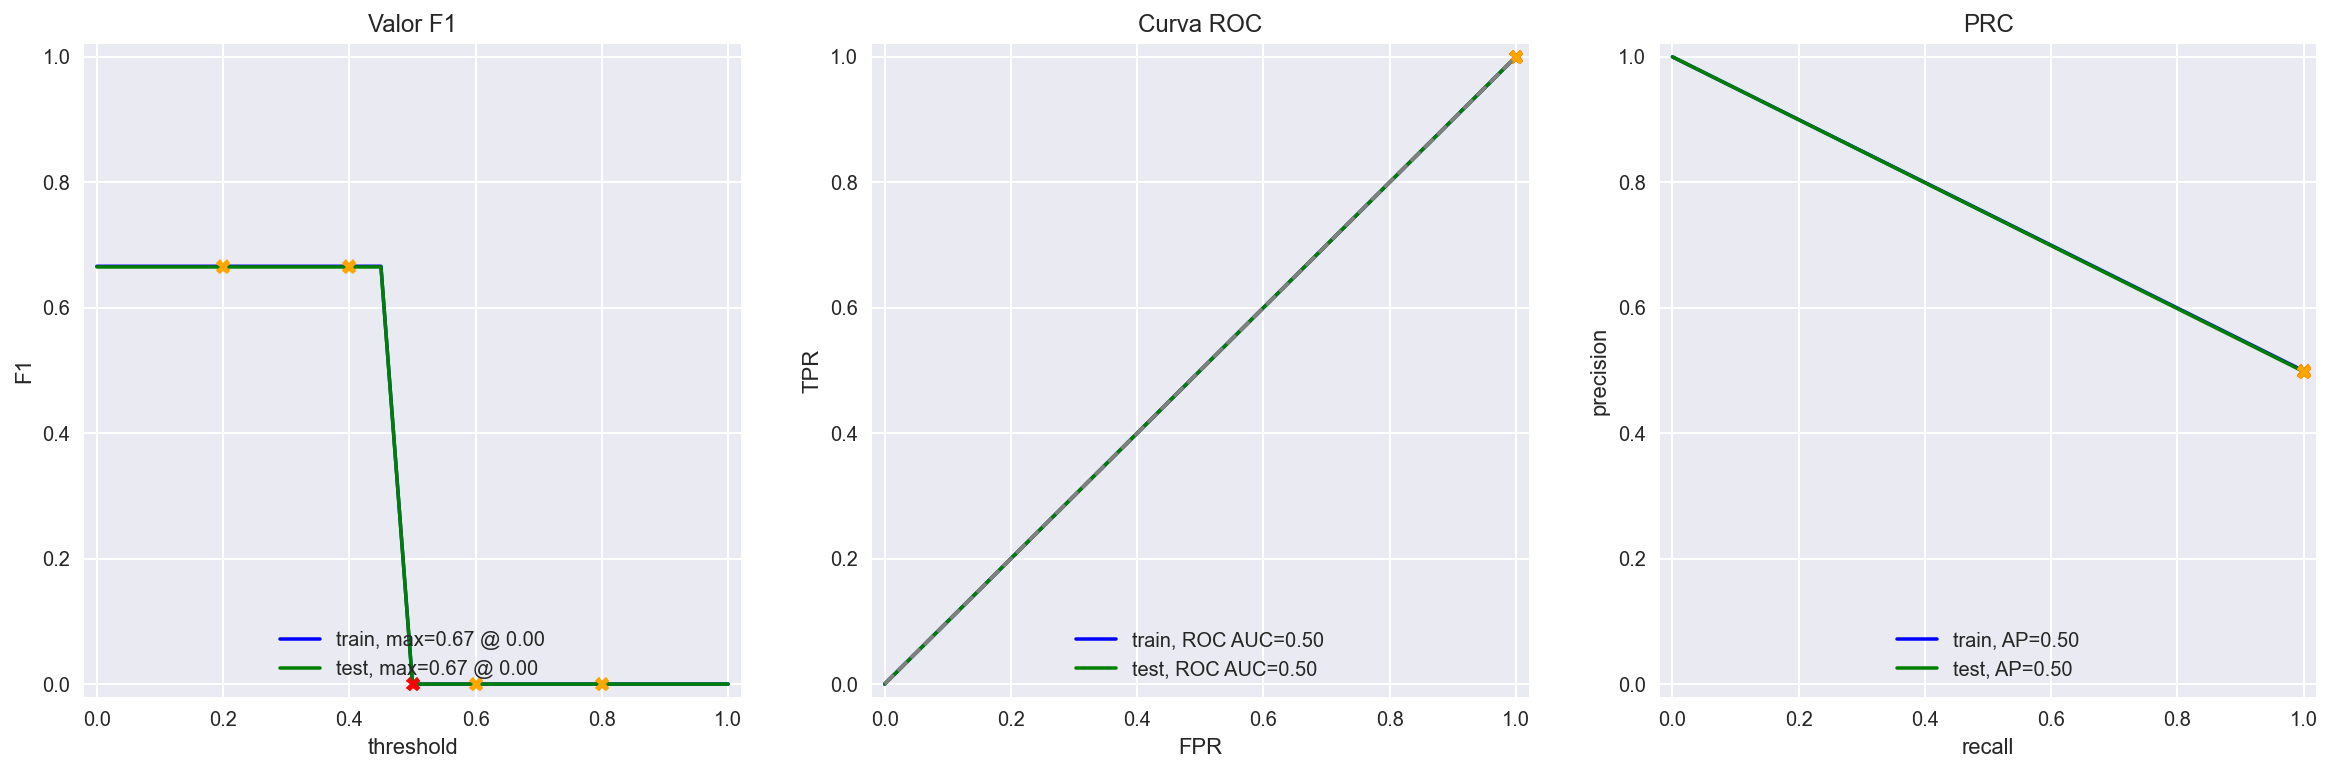

In [32]:
# Evaluation dummy model
evaluate_model(model_0, f_train_rev, train_target, f_test_rev, test_target)

The model has a score of 0.50 (see ROC curve) and an F1 value of 0, so the model needs to be improved.

### Model 1 - NLTK, TF-IDF y LR

TF-IDF will now predict review sentiment using the importance of a given word. This is determined by the value of **TF-IDF** (Term Frequency — Inverse Document Frequency).

* TF is the frequency with which a word appears in a text, while
* IDF measures its frequency of appearance in the corpus.

Additionally, we will eliminate the words that by themselves do not add weight to the sentiment of the review (i.e. stop words).

In [33]:
# Getting features using WordNetLemmatizer as 'lemmatizer'

train_corpus = []
test_corpus =  []

#Training corpus
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    train_corpus.append(l_join)

#Test corpus
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    test_corpus.append(l_join)

In [34]:
# Corpus vectorization with TF-IDF Vectorizer and Stop words
vectorizer_mod1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features_mod1 = vectorizer_mod1.fit_transform(train_corpus)
test_features_mod1 = vectorizer_mod1.transform(test_corpus)

In [35]:
# Logistic regression model
model_1 = LogisticRegression(random_state=12345, max_iter=100)

# Model fit
model_1.fit(train_features_mod1, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


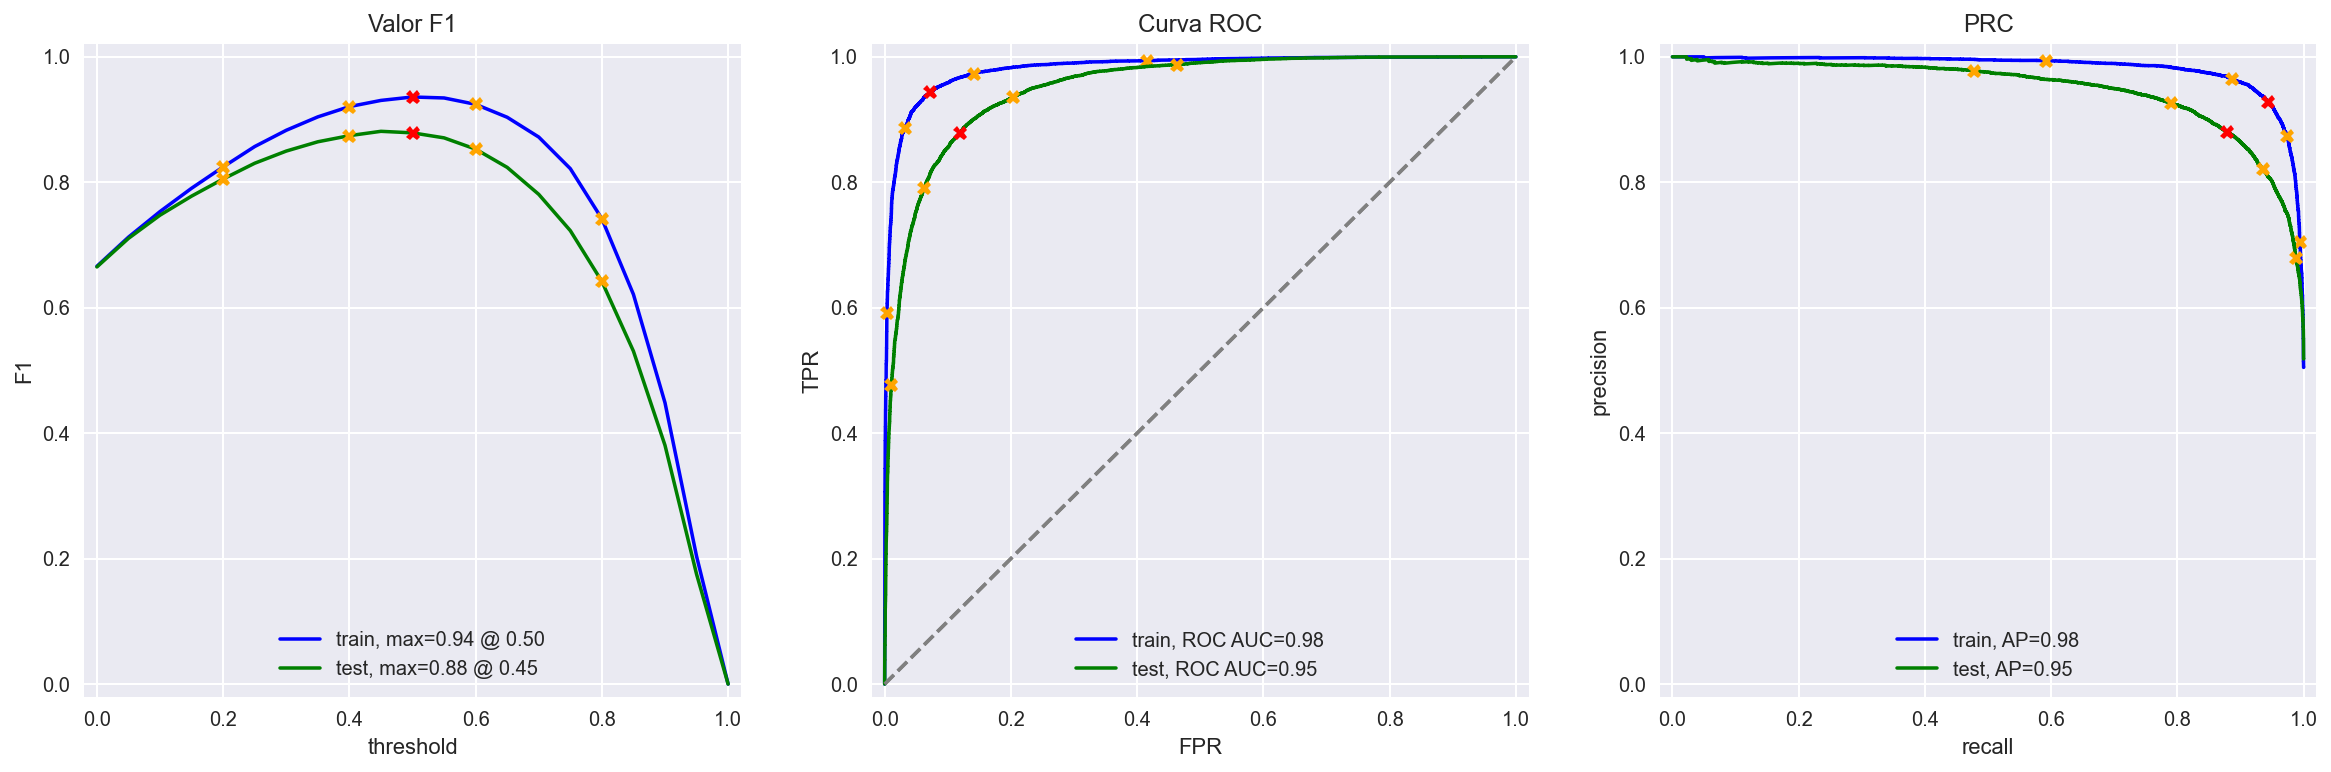

In [36]:
# Model 1 Logistic regression evaluation with NLTK
evaluate_model(model_1, train_features_mod1, train_target, test_features_mod1, test_target)

The **F1-score** of the logistic regression model using the lemmatized checks and stop words, was **0.88** on the test data, which is much better than our dummy model and slightly above the value of F1 required.

### Model 2 - spaCy, TF-IDF and LR

The second model will use spaCy for revision processing. Processing also employs stop words.

In [37]:
# Function for text processing

def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [38]:
# Obtaining corpus for each set using 'text_preprocessing_3'
train_corpus2 = []
test_corpus2  = []

# Training corpus
for text in df_reviews_train['review_norm']:
    result=text_preprocessing_3(text)
    train_corpus2.append(result)

# Test corpus
for text in df_reviews_test['review_norm']:
    result=text_preprocessing_3(text)
    test_corpus2.append(result)

In [39]:
# Corpus vectorization with TF-IDF Vectorizer and Stop words
vectorizer_mod2 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features_mod2 = vectorizer_mod2.fit_transform(train_corpus2)
test_features_mod2  = vectorizer_mod2.transform(test_corpus2)

In [40]:
# Logistic regression
model_2 = LogisticRegression(random_state=12345, max_iter=100)

# Model fit
model_2.fit(train_features_mod2, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


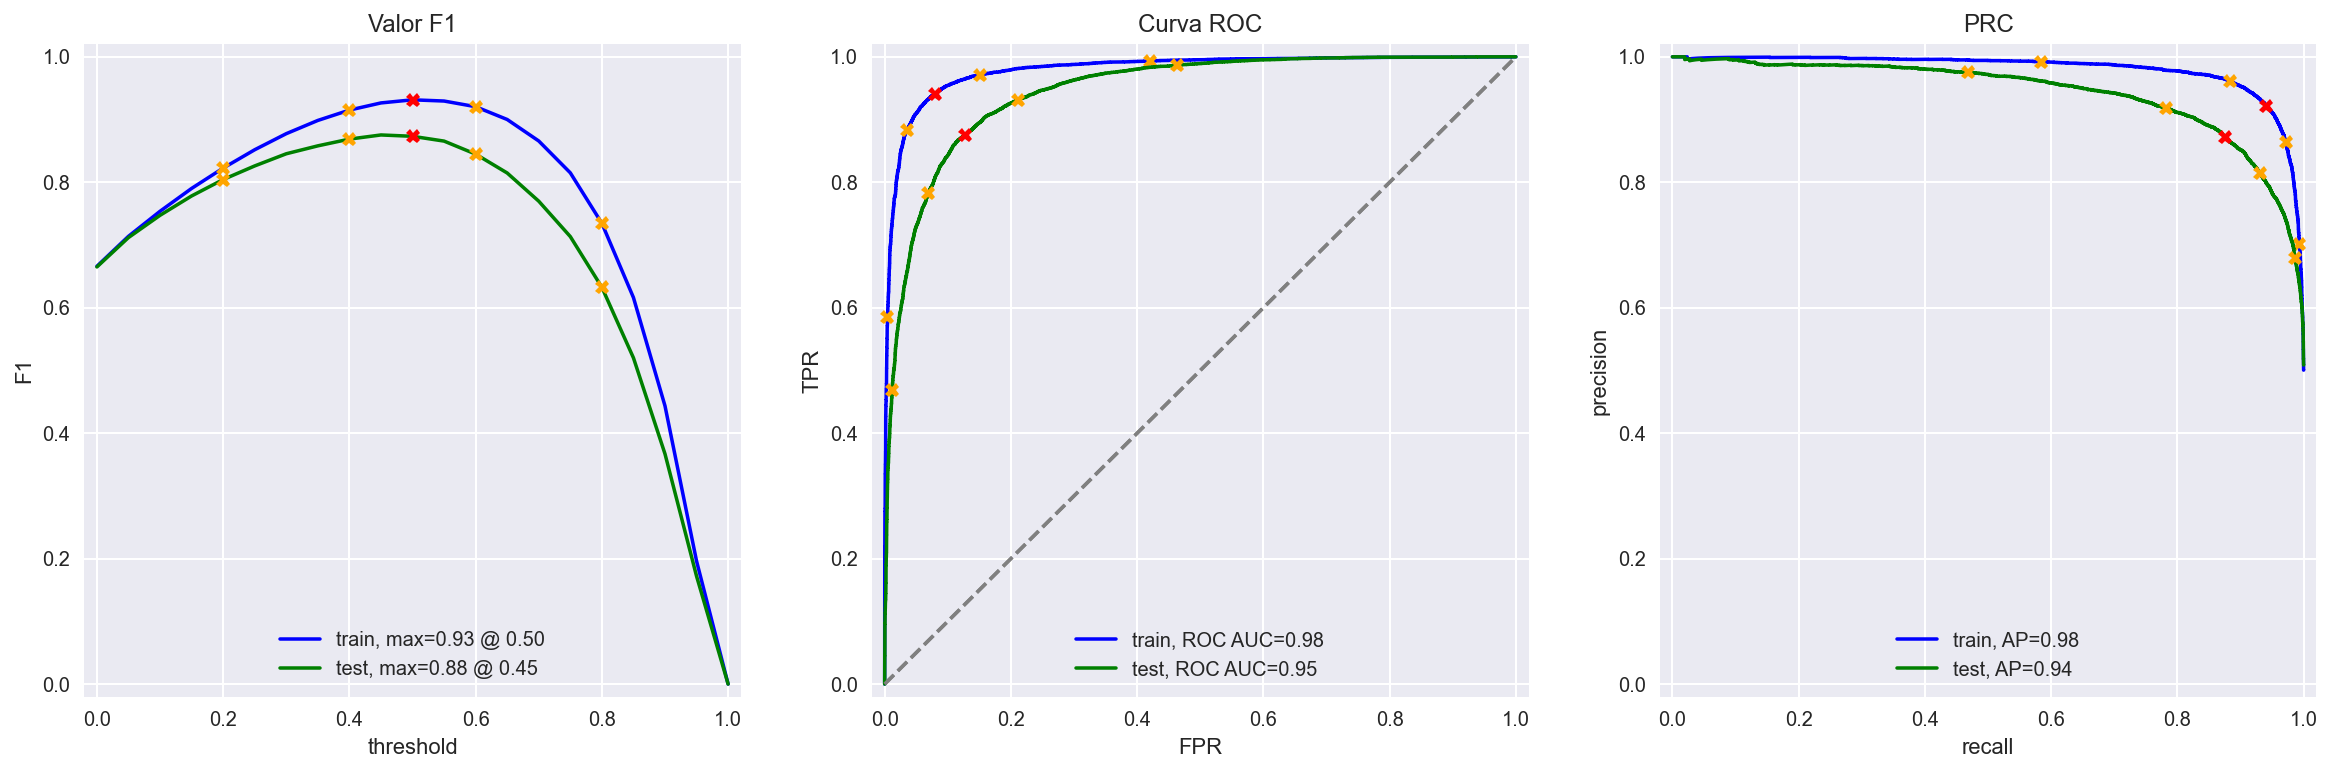

In [41]:
# Model 2 logistic regression evaluation with spaCy
evaluate_model(model_2, train_features_mod2, train_target, test_features_mod2, test_target)

Our second logistic regression model performed only 0.01 lower in accuracy (0.87) and F1 value (**0.87**) than our previous model.

### Model 3 - spaCy, TF-IDF y LGBMClassifier

Now I will train a gradient descent model with lightGBM. This model will be trained using the lemmatized and vectorized revisions in the same way as it was done for model 2, so the characteristics used in model 2 will be the same for model 3.

The lightGBM model has different parameters whose optimal combination will be searched by `GridSearchVC` using only 3 blocks. With the parameters obtained, the model 3 based on lightGBM is built, and finally it is evaluated.

In [42]:
# Training characteristics same as the model 2
train_features_mod3 = train_features_mod2
test_features_mod3  = test_features_mod2

In [43]:
# LightGBM model 
model_3 = LGBMClassifier()

# Tuning parameters
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[12345]}

# GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model_3, param_grid=parameters, scoring='f1', cv=3, verbose=0)
grid.fit(train_features_mod3, train_target)

# Optimal parameters
best_param = grid.best_params_
print(best_param)

{'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'objective': 'binary', 'random_state': 12345}


In [45]:
# LGBM model with optimal parameters
model_3 = LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=20, objective='binary', random_state=12345)
model_3.fit(train_features_mod3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=20,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.87  0.84
F1         0.87  0.84
APS        0.95  0.92
ROC AUC    0.95  0.92


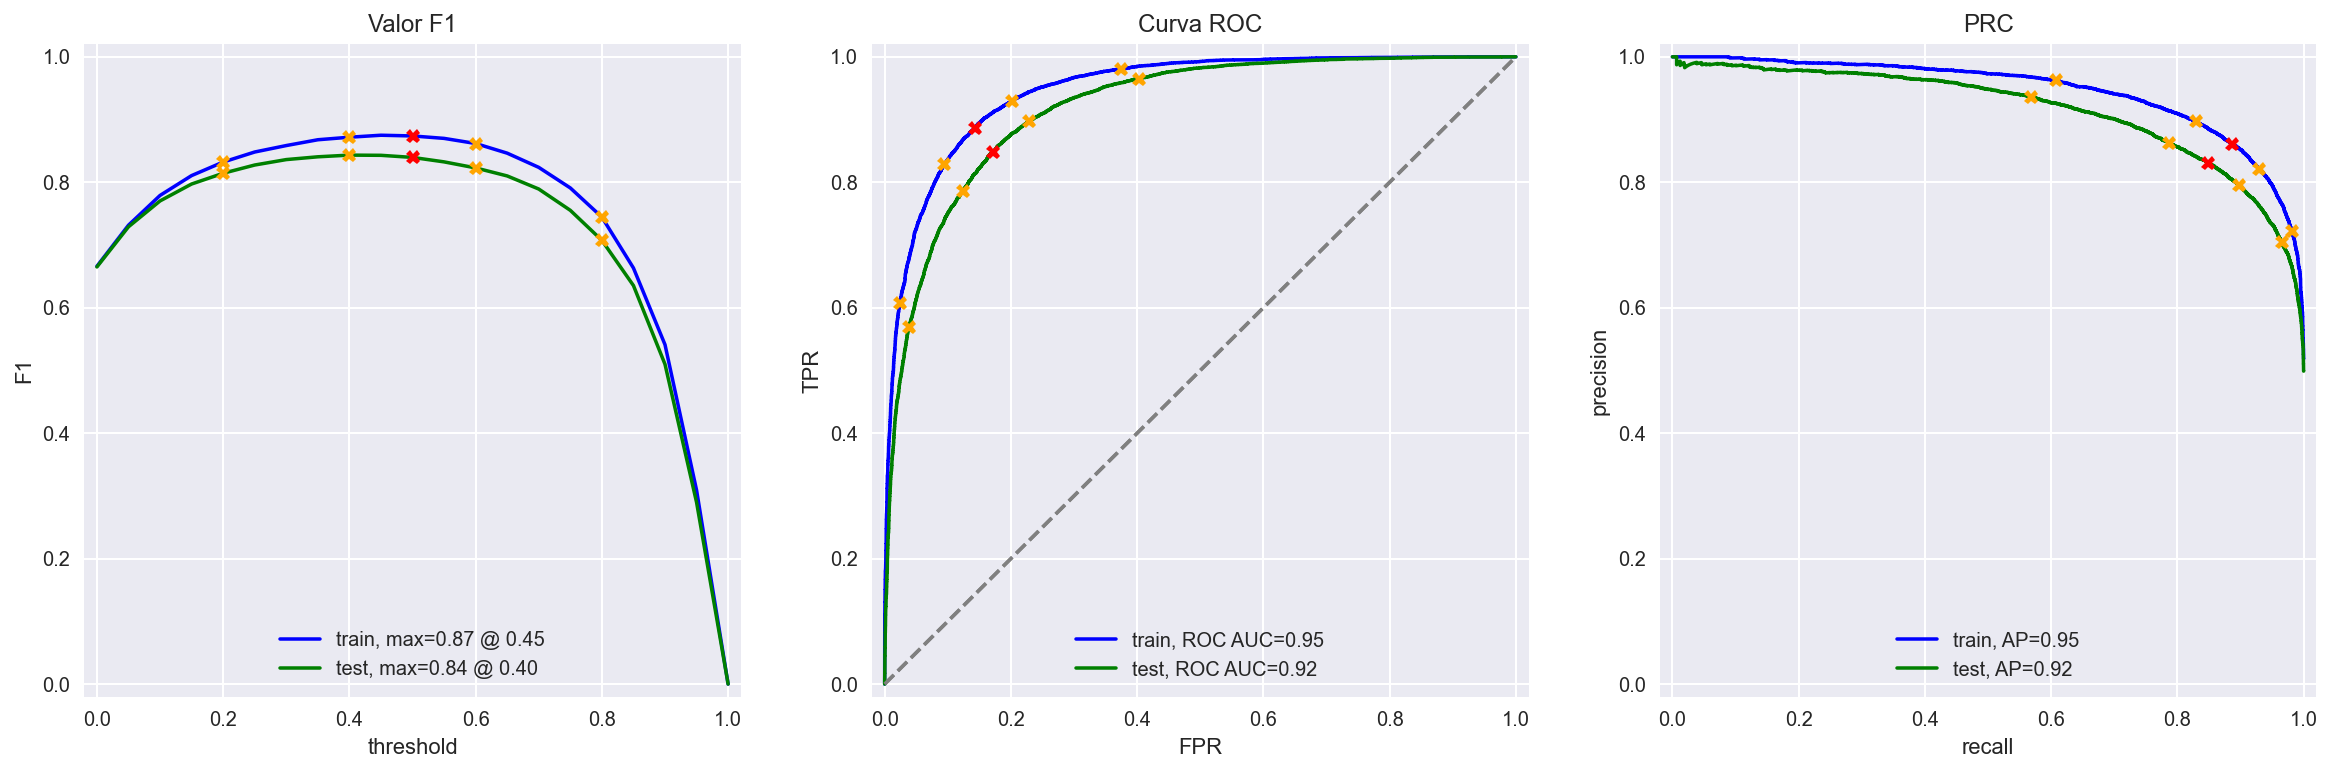

In [46]:
# Model 3 LigthGBM evaluation
evaluate_model(model_3, train_features_mod3, train_target, test_features_mod3, test_target)

The lightGMB model returned an F1 value of **0.84**, which is below the linear regression model but reaching the required F1 threshold.

###  Modelo 4 - BERT 

Finally, I will run a BERT model using BERT embeddings.

In [47]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [1]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to tokens padding id along with their attention masks     
    min_tokenized_text_length = 1e7
    max_tokenized_text_length = 0
    
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
        if len(ids) < min_tokenized_text_length:
            min_tokenized_text_length = len(ids)
        
        if len(ids) > max_tokenized_text_length:
            max_tokenized_text_length = len(ids)

    # Set GPU o CPU for running the model             
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # get embeddings in batches
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [16]:
## Subsample of 500 reviews for training

sample_size = 500

# Features
features_train_bert = df_reviews_train['review_norm'].iloc[:sample_size]
features_test_bert = df_reviews_test['review_norm'].iloc[:sample_size]

# Target
train_target_bert = df_reviews_train['pos'].iloc[:sample_size]
test_target_bert = df_reviews_test['pos'].iloc[:sample_size]

In [ ]:
# Training features
train_features_9 = BERT_text_to_embeddings(features_train_bert, force_device='cpu')

In [ ]:
# Test features
test_features_9 = BERT_text_to_embeddings(features_test_bert, force_device='cpu')

In [ ]:
# Size of features datasets
print(train_features_9.shape)
print(train_target_bert.shape)

print(test_features_9.shape)
print(test_target_bert.shape)

In [4]:
# if you already got the ones inserted, we recommend saving them to have them ready. Use:
#np.savez_compressed('features_9_500.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# Load
with np.load('datasets/features_9_500.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

Since we have obtained the BERT inserts for 500 revisions, we are going to perform a logistic regression and evaluate the model.

In [5]:
# Logistic regression with BERT
model_4 = LogisticRegression()

# Model fitting BERT
model_4.fit(train_features_9, train_target_bert)

NameError: name 'train_target_bert' is not defined

          train  test
Accuracy   0.99  0.81
F1         0.99  0.82
APS        1.00  0.91
ROC AUC    1.00  0.90


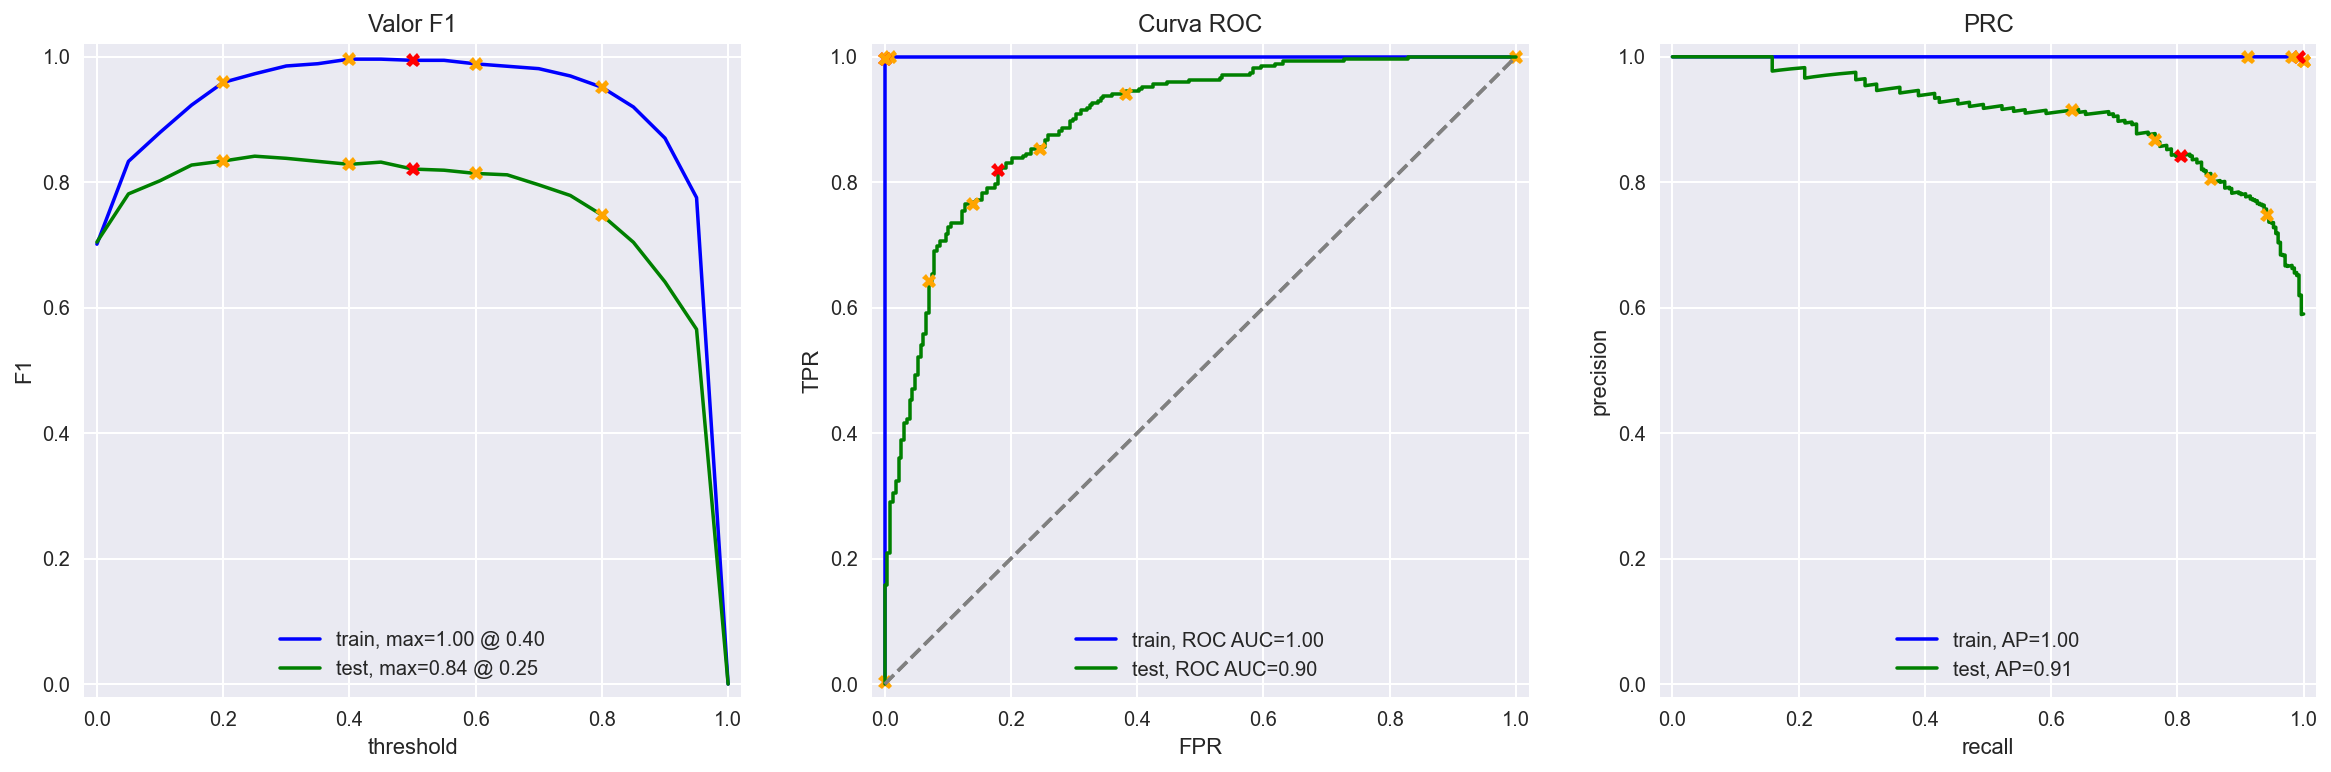

In [19]:
# Model 4 Logistic evaluation with BERT
evaluate_model(model_4, train_features_9, train_target_bert, test_features_9, test_target_bert)

Our fourth logistic regression model with BERT inserts had an accuracy of only 0.81 and an F1 value of **0.82**.

Despite this poor performance, it must be taken into account that this model was trained with only 500 revisions due to its high computational demand. However, the value of F1 was very close to the required quality threshold.

## My reviews 

In this section I will test the performance of the models using "artificial" reviews. This artificial reviews will be standarized, and gets the probability of being a positive review. In this regard probability values range from `0` (i.e. negative review) to `1` (i.e. positive review). Reviews with values of `0.5` are not clearly distinguish of being positive or negative. 

In [20]:
# Artificial reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Standarization
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middle of the movie.",well i was bored and felt asleep in the middle of the movie
2,I was really fascinated with the movie,i was really fascinated with the movie
3,"Even the actors looked really old and disinterested, and they got paid to be...",even the actors looked really old and disinterested and they got paid to be ...
4,I didn't expect the reboot to be so good! Writers really cared about the sou...,i didn t expect the reboot to be so good writers really cared about the sour...
5,"The movie had its upsides and downsides, but I feel like overall it's a dece...",the movie had its upsides and downsides but i feel like overall it s a decen...
6,"What a rotten attempt at a comedy. Not a single joke lands, everyone acts an...",what a rotten attempt at a comedy not a single joke lands everyone acts anno...
7,Launching on Netflix was a brave move & I really appreciate being able to bi...,launching on netflix was a brave move i really appreciate being able to bing...


Reviews with the index 0, 1, 3 and 6 are negative reviews; while the reviews with the index 2, 4 and 5 and 7 are positive reviews.

Let's test whether the models correctly predict review sentiment.

### Model 1 - NLTK, TF-IDF y LR

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_mod1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didn t expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The first model gives probabilities below 50% to positive opinions with the index `4` (0.36). While the opinions with the index `2` and `5` have a probability close to 50% with 0.57 and 0.51 respectively. Only the revision with the index `7` had an acceptable probability.

Perhaps this performance is due to the fact that the review contains phrases that could denote some ambiguity such as the reviews with the index `4` and `5` which have phrases that could be interpreted as negative by themselves.

### Model 2 - spaCy, TF-IDF and LR

In [36]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vectorizer_mod2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn t expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The second model decreases your chances of classifying a review as positive for indices `2` (0.49), `4` (0.23) and `5` (0.39). Likewise, revision `7` had a better probability.

Apparently this model compared to the previous model, this model penalizes reviews more harshly with certain words that could be considered negative. The only review that was classified as positive (>50% probability) was the review with the index `7`.

### Model 3 - LightGBM

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_mod2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it not my kind of movie
0.31:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.49:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.74:  i didn t expect the reboot to be so good writers really cared about the source material
0.56:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.40:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.68:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Model 3 performed the best in predicting how to classify a review as all positive reviews had at least a greater than 50% probability of being rated positive.

### Model 4 - BERT embeddings

In [22]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.83:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.90:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.50:  i didn t expect the reboot to be so good writers really cared about the source material
0.98:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The BERT embedded model performs very poorly in predicting whether a revision is positive or not. Again this is due to the limited dataset the model was trained on.

### Model comparisons

In [6]:
models = pd.DataFrame({'model':['NLTK','spaCy','LGBM','BERT'],
                       'Exactitud':[0.88, 0.87, 0.84, 0.81],
                       'F1':[0.88, 0.87, 0.84, 0.82]})

models

,model,Exactitud,F1
0,NLTK,0.88,0.88
1,spaCy,0.87,0.87
2,LGBM,0.84,0.84
3,BERT,0.81,0.82


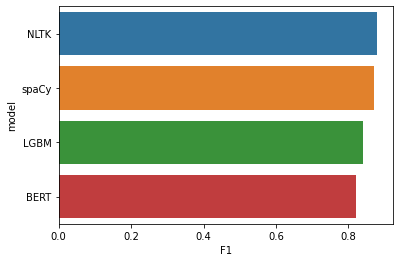

In [8]:
sns.barplot(x="F1", y="model", data=models,
            label="F1")
plt.show()

The graph shows the performance of each model according to its F1, the model trained with NLTK was the one that obtained the highest score. However, the model that performed best in predicting our review sentiment was the lightGBM-based model.

## Conclusions

In this project I created different models with slight modifications in the word processing for training the models. The goal of the models was to predict whether a review would be positive or negative. The models were compared according to their F1 value. The logistic regression model using NLTK processing and TF-IDF vectorization with stop words had the highest score (**0.88**). However, when ranking new reviews, the lightGBM model was the best at ranking positive reviews, while the contending models performed better at ranking negative reviews but at risk of false negatives.